<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# Transformers Fine Tuning

by Fabian Märki

## Summary
The aim of this notebook is to show how to fine tune a pretrained model for sequence classification.


## Links
- [Fine-tune a pretrained model](https://huggingface.co/docs/transformers/training)
- [Course](https://huggingface.co/course/chapter1) on how to use Huggingface's transformer models (from simple using pipelines to complex implementing the training loop).
- [Notebooks](https://huggingface.co/docs/transformers/notebooks) on a different topics (fine tuning,  translation, summarization, question answering, audio classification, image classification etc.)


<a href="https://colab.research.google.com/github/markif/2023_HS_DAS_NLP_Notebooks/blob/master/08_b_Transformers_Text_Classifier_FineTuning.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture

!pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'

from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.system import set_log_level

import pandas as pd
import numpy as np

set_log_level()
import tensorflow as tf

**Make sure that a GPU is available (see [here](https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm))!!!**

In [2]:
from fhnw.nlp.utils.system import system_info
print(system_info())

OS name: posix
Platform name: Linux
Platform release: 5.19.0-41-generic
Python version: 3.8.10
CPU cores: 6
RAM: 31.12GB total and 26.31GB available
Tensorflow version: 2.12.0
GPU is available
GPU is a NVIDIA GeForce RTX 2070 with Max-Q Design with 8192MiB


In [3]:
%%time
download("https://drive.switch.ch/index.php/s/0hE8wO4FbfGIJld/download", "data/german_doctor_reviews_tokenized.parq")
data = load_dataframe("data/german_doctor_reviews_tokenized.parq")

CPU times: user 7.17 s, sys: 1.35 s, total: 8.51 s
Wall time: 4.79 s


In [4]:
# remove all neutral sentimens
data = data.loc[(data["label"] != "neutral")]
data.shape

(331187, 10)

In [5]:
data.head(3)

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1,"[ich, bin, franzose, und, bin, seit, ein, paar...",ich bin franzose und bin seit ein paar wochen ...,"[franzose, seit, paar, wochen, muenchen, zahn,...","[franzos, seit, paar, woch, muench, ., zahn, s...","[franzose, seit, paar, wochen, muenchen, ., za..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1,"[hatte, akute, beschwerden, am, rücken, ., her...",hatte akute beschwerden am rücken . herr magur...,"[akut, beschwerden, rücken, magura, erste, arz...","[akut, beschwerd, ruck, ., magura, erst, arzt,...","[akute, beschwerden, rücken, ., magura, erste,..."


In [6]:
%%capture

!pip install torch
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install accelerate

In [7]:
from fhnw.nlp.utils.transformers import dataframe_to_dataset
from fhnw.nlp.utils.transformers import dataframe_to_datasets
from fhnw.nlp.utils.transformers import get_compute_device

In [8]:
params = {
    "verbose": True,
    "shuffle": True,
    "n_samples": len(data),
    # modify batch_size in case you experience memory issues
    "batch_size": 8,
    "X_column_name": "text",
    "y_column_name": "label",
    "y_column_name_prediction": "prediction",
    "compute_device": get_compute_device(),
    "transformers_model_name": "distilbert-base-multilingual-cased",
    #"transformers_model_name": "bert-base-multilingual-uncased",
}

In [9]:
def dataframe_to_datasets(params, data, data_test=None):
    """Converts a dataframe into a Huggingface dataset dictionary with a train, val and test split

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    data: dataframe
        The data
    data_test: dataframe
        The user defined test split (use None to automatically generate a test split)  
        
    Returns
    -------
    dataset
        The Huggingface dataset dictionary
    """
    
    import pandas as pd
    from fhnw.nlp.utils.params import compute_binarized_labels
    from fhnw.nlp.utils.params import create_label_binarizer_and_set
    from fhnw.nlp.utils.params import get_train_test_split
    
    from datasets import ClassLabel
    from datasets import Dataset
    from datasets import DatasetDict
    
    X_column_name = params.get("X_column_name", "text")
    y_column_name = params.get("y_column_name", "label")
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    
    data = data.drop(labels=data.columns.difference([X_column_name, y_column_name]), axis=1)

    # ensure label_binarizer builds on all data (function dataframe_to_dataset will use the existing)
    label_binarizer = params.setdefault(computed_objects_column_name, {}).get("label_binarizer", None)
    if label_binarizer is None:
        create_label_binarizer_and_set(params, data)
        label_binarizer = params[computed_objects_column_name]["label_binarizer"]
    
    # do the split
    if data_test is None:
        data, data_test = get_train_test_split(params, data)
    data_train, data_val = get_train_test_split(params, data)

    dataset_train = dataframe_to_dataset(params, data_train)
    dataset_test = dataframe_to_dataset(params, data_test)
    dataset_val = dataframe_to_dataset(params, data_val)
    
    transformers_datasets = DatasetDict({"train":dataset_train, "validation":dataset_val, "test":dataset_test})
    
    params.setdefault(computed_objects_column_name, {})["transformers_datasets"] = transformers_datasets
    
    return transformers_datasets

In [10]:
datasets = dataframe_to_datasets(params, data)

Inferred classification type: binary
264949 train examples
66238 test examples
211959 train examples
52990 test examples


Changing max_length (to e.g. `input_sequence_length` or even smaller) can greatly speedup training and can even help to converge training.

In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(params["transformers_model_name"])

def tokenize_function(examples):
    X_column_name = params.get("X_column_name", "text")
    input_sequence_length = params.get("input_sequence_length", 256)
    
    return tokenizer(
        examples[X_column_name], 
        #padding=True,
        #max_length=input_sequence_length,
        padding="max_length",
        truncation=True,
    )

tokenized_datasets = datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/211959 [00:00<?, ? examples/s]

Map:   0%|          | 0/52990 [00:00<?, ? examples/s]

Map:   0%|          | 0/66238 [00:00<?, ? examples/s]

In [12]:
%%time

print("Text: ", tokenizer.convert_ids_to_tokens(tokenized_datasets["test"]["input_ids"][0])[0:30])
print("IDs: ", tokenized_datasets["test"]["input_ids"][0][0:30])

Text:  ['[CLS]', 'die', 'pra', '##xis', 'und', 'dr', '.', 'ander', '##ya', 'sind', 'sehr', 'zu', 'em', '##pf', '##eh', '##len', 'f', '##ühl', '##te', 'mich', 'er', '##nst', '##genommen', 'und', 'sehr', 'gut', 'auf', '##gehoben', 'die', 'op']
IDs:  [101, 10128, 69857, 53496, 10130, 17094, 119, 23336, 10679, 10762, 14483, 10304, 10266, 55942, 25723, 11608, 174, 48288, 10216, 52866, 10163, 40300, 29789, 10130, 14483, 23639, 10329, 77630, 10128, 10303]
CPU times: user 20.8 s, sys: 313 ms, total: 21.1 s
Wall time: 21 s


In [13]:
train_dataset = tokenized_datasets["train"].shuffle(seed=42)
eval_dataset = tokenized_datasets["test"]
#train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
#eval_dataset = tokenized_datasets["test"].select(range(1000))

In [14]:
from transformers import AutoModelForSequenceClassification

computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
label_binarizer = params[computed_objects_column_name]["label_binarizer"]
num_classes = len(label_binarizer.classes_)

model = AutoModelForSequenceClassification.from_pretrained(params["transformers_model_name"], num_labels=num_classes)

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'pre_classifie

In [15]:
import numpy as np
import evaluate

#metric = evaluate.load("accuracy")
metric = evaluate.combine(["accuracy", "recall", "precision", "f1"])

In [16]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [17]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    num_train_epochs = params.get("training_epochs", 3),
    report_to = "none",
    output_dir = "test_trainer", 
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit = 1,
    #evaluation_strategy ="steps",
    #eval_steps = 10, # Evaluation and Save happens every 10 steps 
    #save_total_limit = 5, # Only last 5 models are saved. Older ones are deleted.
    load_best_model_at_end = True,
    #auto_find_batch_size = True,
    per_device_train_batch_size = params.get("batch_size", 4),  # batch size per device during training
    per_device_eval_batch_size = 2*params.get("batch_size", 4), # batch size for evaluation
)

In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [19]:
%%time

train_result = trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.184900,0.245130,0.933044,0.942415,0.982500,0.962040
2,0.192500,0.192454,0.960944,0.976574,0.979975,0.978272
3,0.142400,0.161290,0.967285,0.986300,0.977562,0.981912


CPU times: user 8h 37min 35s, sys: 38.8 s, total: 8h 38min 14s
Wall time: 8h 38min


let's store all this work fist as it took quite a while...(on different hardware I experienced ~3h 32min for distilbert-base-multilingual and ~6h 43min for bert-base-multilingual)

In [20]:
model_path = "data/"+params["transformers_model_name"]+"-sentiment"

model.save_pretrained(model_path)
_ = tokenizer.save_pretrained(model_path)

Let's put this into a Pipeline (see also [here](https://huggingface.co/docs/transformers/add_new_pipeline))

In [21]:
from transformers import Pipeline

class DoctorReviewsSentimentPipeline(Pipeline):
    
    def _sanitize_parameters(self, **kwargs):
        preprocess_kwargs = {}
        if "input_sequence_length" in kwargs:
            preprocess_kwargs["input_sequence_length"] = kwargs["input_sequence_length"]
        return preprocess_kwargs, {}, {}

    def preprocess(self, text, input_sequence_length=256):
        # max_length can have a major performance impact (choose it wisely).
        # if there are occasional very long sentence compared to the others, 
        # the whole batch will need to be 256 tokens long (i.e. [batch_size, 256]),
        # leading to a slowdown (on bigger batches the program might even crash).
        #
        # So it could make sense to choose a shorter input_sequence_length
        # (however, there is a tradeoff between model performance vs. compute performance)
        return self.tokenizer(text, 
                              padding=True, 
                              truncation=True, 
                              max_length=input_sequence_length, 
                              return_tensors=self.framework)

    def _forward(self, model_inputs):
        return self.model(**model_inputs)

    def postprocess(self, model_outputs):
        import torch
        import numpy as np 
        
        predictions = np.argmax(model_outputs.logits, axis=-1)

        if len(predictions) > 1:
            return ["positive" if pred == 1 else "negative" for (idx,pred) in enumerate(predictions)]
        else:
            return "positive" if predictions[0] == 1 else "negative"

In [22]:
from transformers.pipelines import PIPELINE_REGISTRY
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification

PIPELINE_REGISTRY.register_pipeline(
    "doctor-reviews-sentiment",
    pipeline_class=DoctorReviewsSentimentPipeline,
    pt_model=AutoModelForSequenceClassification,
    tf_model=TFAutoModelForSequenceClassification,
    #default={"pt": (model_name, model_version)},
    type="text",
)

In [23]:
from transformers import pipeline

sentiment_pipeline = pipeline("doctor-reviews-sentiment", 
                              model = model_path,
                              device = params.get("compute_device", "cpu"),
                              input_sequence_length = params.get("input_sequence_length", 256)
                             )

In [24]:
sentiment_pipeline(data[params["X_column_name"]].head(3).tolist())

['positive', 'negative', 'positive']

In [25]:
from transformers.pipelines.pt_utils import KeyDataset

batch_size = params.get("batch_size", 16)

dataset_test = datasets["test"]
dataset_val = datasets["validation"]
dataset_train = datasets["train"]

pred_iter_test = sentiment_pipeline(KeyDataset(dataset_test, params["X_column_name"]), batch_size=batch_size)
pred_iter_val = sentiment_pipeline(KeyDataset(dataset_val, params["X_column_name"]), batch_size=batch_size)
pred_iter_train = sentiment_pipeline(KeyDataset(dataset_train, params["X_column_name"]), batch_size=batch_size)

In [26]:
%%time 

# evaluate PipelineIterator
preds_test = [x for x in pred_iter_test]
preds_val = [x for x in pred_iter_val]
preds_train = [x for x in pred_iter_train]

CPU times: user 22min 19s, sys: 116 ms, total: 22min 19s
Wall time: 22min 19s


In [27]:
labels_test = ["positive" if label == 1 else "negative" for label in dataset_test["label"]]
labels_val = ["positive" if label == 1 else "negative" for label in dataset_val["label"]]
labels_train = ["positive" if label == 1 else "negative" for label in dataset_train["label"]]

Set Population: 331187
Accuracy: 0.9686


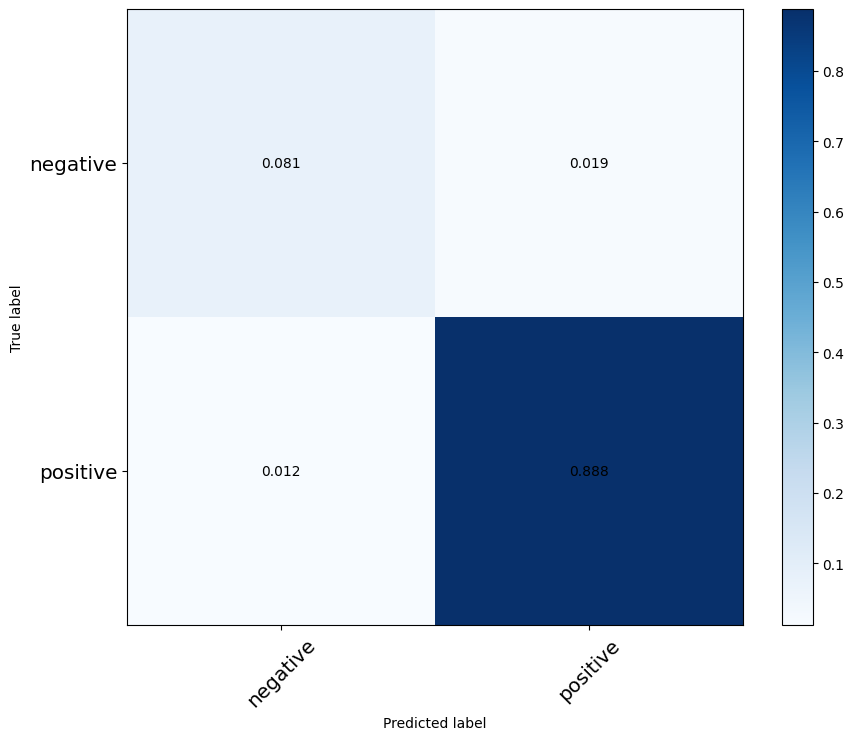

              precision    recall  f1-score   support

    negative       0.87      0.81      0.84     33022
    positive       0.98      0.99      0.98    298165

    accuracy                           0.97    331187
   macro avg       0.92      0.90      0.91    331187
weighted avg       0.97      0.97      0.97    331187



In [28]:
from fhnw.nlp.utils.ploting import report_classification_results

report_classification_results(params, labels_test + labels_val + labels_train, preds_test + preds_val + preds_train)

Set Population: 66238
Accuracy: 0.9663


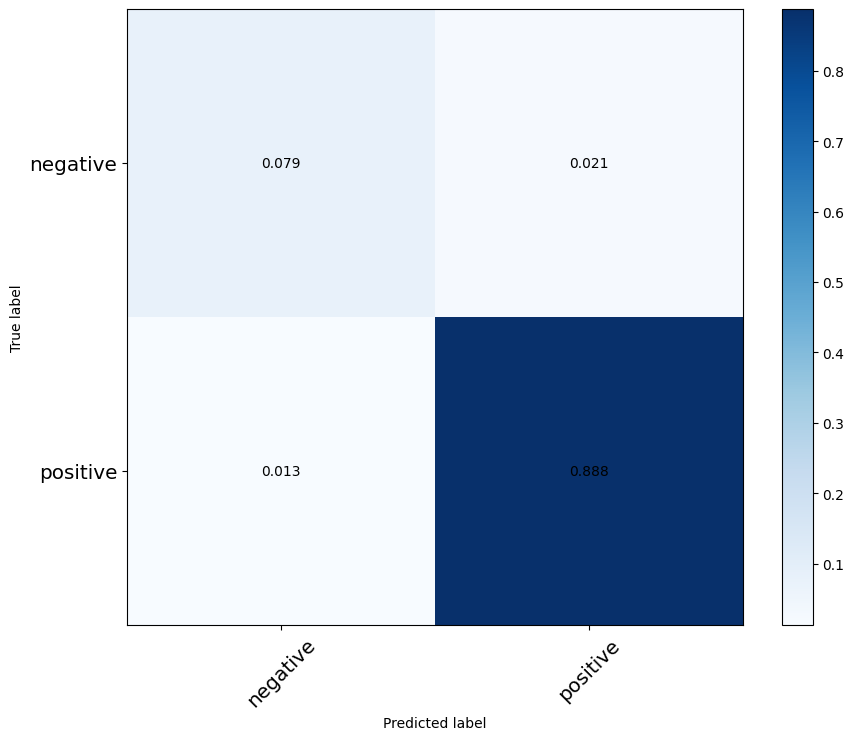

              precision    recall  f1-score   support

    negative       0.86      0.79      0.82      6604
    positive       0.98      0.99      0.98     59634

    accuracy                           0.97     66238
   macro avg       0.92      0.89      0.90     66238
weighted avg       0.97      0.97      0.97     66238



In [29]:
report_classification_results(params, labels_test, preds_test)